# Optimized deep neural networks learning poker hands

This data set contains examples of possible poker hands which can be used to let a machine learning algorithm learn the rules of the game. It was used in a [research paper](https://pdfs.semanticscholar.org/c068/ea7807367573f4b5f98c0681fca665e9ef74.pdf) in which the authors, R. Cattral, F. Oppacher, and D. Deugo, used evolutionary and symbolic machine learning methods to extract comprehensible and strong rules (the rules of poker in this case) from it. We will try to achieve this with an optimized neural network.

The data set was contributed to the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Poker+Hand) by Robert Cattral and Franz Oppacher from the Department of Computer Science of Carleton University, which is where I got it from.

## Frame the Problem
In this small project, we're not going all the way to building a full poker-bot that can play the entire game of poker against other agents. We just want to see if and how well an algorithm can understand the rules of how poker hands (the combination of cards that result in a certain score) are composed.

The data we will consider contains one million instances of poker hands. Each poker hand in the data set is an example consisting of five cards which are drawn from a poker deck of 52 cards. Each card has two attributes, its suit (S, 1 to 4, representing Hearts, Spades, Diamonds, and Clubs) and its rank (C, 1 to 13, representing Ace, 2, 3, ... , Queen, and King). For each instance (poker hand) that results in 10 features. There are ten possible classes (0 to 9) which correspond to the card [combinations](https://en.wikipedia.org/wiki/Poker#Gameplay) that can be observed in the game of poker: nothing in hand, one pair, two pairs, three of a kind, straight, flush, full house, four of a kind, straight flush, and royal flush.

We will treat this as a supervised multi-class classification problem. The rules of this classification are fairly complicated but we also have a lot of instances to train on, which makes the problem very suitable for deep neural networks. We will work with a multilayer perceptron architecture, implement it with `TensorFlow 2.0`'s `Keras` API, and optimize its hyper-parameters with the `hyperas` library using a bayesian optimization.

In [1]:
# import the libraries we'll need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style("darkgrid")
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import tensorflow.keras as keras

## Data preparation
Let's import the data into data frame hand have a look.

In [2]:
# import data from CSV file
df = pd.read_csv("poker-hand-testing.data",
                 names = ["S1","C1","S2","C2","S3","C3",
                          "S4","C4","S5","C5","target"])

# order the columns to have the ranks (C, numerical) 
# and suits (S, categorical) together
df = df[["C1","C2","C3","C4","C5",
         "S1","S2","S3","S4","S5",
         "target"]]

# let's have a look by taking a random sample
df.sample(10)

,C1,C2,C3,C4,C5,S1,S2,S3,S4,S5,target
808385,3,8,6,12,3,4,1,3,4,3,1
234800,9,12,5,10,5,3,2,3,3,2,1
196245,12,6,7,3,9,4,3,2,2,2,0
609543,12,11,13,6,8,2,3,2,3,3,0
961547,11,3,11,10,6,3,2,4,4,4,1
325426,9,12,4,4,6,2,2,3,2,1,1
752949,13,7,4,6,2,4,4,4,1,2,0
958119,1,6,6,13,10,4,1,4,4,4,1
116907,1,10,8,4,11,3,4,1,2,1,0
439993,2,9,4,8,2,1,3,2,2,4,1


In [3]:
# print the data frame's info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
C1        1000000 non-null int64
C2        1000000 non-null int64
C3        1000000 non-null int64
C4        1000000 non-null int64
C5        1000000 non-null int64
S1        1000000 non-null int64
S2        1000000 non-null int64
S3        1000000 non-null int64
S4        1000000 non-null int64
S5        1000000 non-null int64
target    1000000 non-null int64
dtypes: int64(11)
memory usage: 83.9 MB


In [4]:
# look for missing values
df.isna().sum()

C1        0
C2        0
C3        0
C4        0
C5        0
S1        0
S2        0
S3        0
S4        0
S5        0
target    0
dtype: int64

We can see that there are apparently no missing values. Let's look at how the target classes are distributed.

In [5]:
df.target.value_counts().sort_index()

0    501209
1    422498
2     47622
3     21121
4      3885
5      1996
6      1424
7       230
8        12
9         3
Name: target, dtype: int64

As we can see, we're dealing with a very strong class imbalance. Some of the poker hands are much rarer than others. We can try to account for this by handing class weights to the classifier but it will certainly be very difficult, if not impossible, to correctly classify e.g. a straight flush or royal flush.

Let's also have a look at how the features are distributed to make sure there are no outliers.

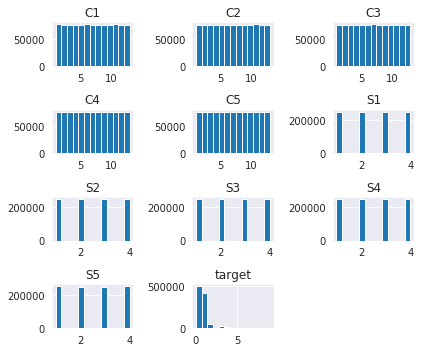

In [6]:
# plot feature distribution as histograms
_ = df.hist(bins=13,figsize=(6,5))
plt.tight_layout()

Great, looks like the data is actually distributed as specified. No need to account for invalid values. We can now proceed to splitting of test and validation data sets. Because of the class imbalance, we will stratify the split so that approximately equal class distributions will be present in all sets. For the very rare classes this may not work perfectly. We'll also compute the class weights already.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# split off a test set and stratify for classes (target)
train_full, test = train_test_split(df,
                                    stratify = df["target"],
                                    test_size=0.2, 
                                    random_state=123)

# split into a training and a validation set and stratify for classes (target)
train, valid = train_test_split(train_full,
                                stratify = train_full["target"],
                                test_size=0.2,
                                random_state=123)

# compute class weigths which will be used to account for class imbalance
class_weights = compute_class_weight("balanced",
                                     np.unique(train["target"]),
                                     train["target"])

I really like using handy `pandas` and `sklearn` functions for exploring and preprocessing moderate-sized data. But for really big data that has to be distributed over several machines, we might prefer to use `dask` data frames or to do everything just in `TensorFlow`. `TensorFlow`'s data API can read data from different sources, handle preprocessing (even though I personally don't always find it very handy), and provide tensor datasets and `TensorFlow` also offers different kinds of feature columns which can be directly fed into a model. We'll use these features here to explore them a bit, even though we could also just use `sklearn`'s preprocessing on `pandas`'s data frames here on my single poor old laptop.

We'll first define a function that turns the `pandas` data frames into `TensorFlow` data sets.

In [8]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    """
    A function that turns pandas data frames into TensorFlow data sets.
    Params:
    ----------
    dataframe: input pandas data frame
    shuffle: if True, the data set will be pre-shuffled
    batch_size: batch size, meaning number of instances that 
                will be passed to model per optimization step
    Returns:
    ---------
    ds: the output data set
    """
    # get copy of data frame
    dataframe = dataframe.copy()
    
    # extract class labels
    labels = dataframe["target"]
    
    # make data set from features (first 10 columns) and labels
    # note: it's important to convert data type from int to float32
    # here, TF doesn't do that automatically and will throw error
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe.iloc[:,:10]
                                                  .astype(np.float32)), 
                                             labels))
    # shuffle if desired
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    # enable infinite repeat with given batch size and prefetch
    ds = ds.repeat().batch(batch_size).prefetch(1)
    
    return ds

Now we can actually transform the data frames into `TensofFlow` data sets which will be fed to our model. But we'll have to choose the batch size first, how many instances will be passed through the model per optimization step.

The batch size should be large enough to give a precise enough estimate of gradients during optimization but not so large that it significantly slows down the training iterations. In practice 32 is often chosen as default. At least that's what I understood from `TensofFlow` tutorials and a couple of deep learning books. I have no reason not to trust this advice here.

In [9]:
batch_size = 32
# create tensorflow data sets from data frames
train_ds = df_to_dataset(train, batch_size=batch_size)
valid_ds = df_to_dataset(valid, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

We will want to normalize the numerical data (first 5 columns) before we send it into the model. We can provide a normalization function to the numerical feature column later but we'll first have to compute each feature's mean and standard deviation. We can compute them as `TensorFlow` tensors as well.

In [10]:
# calculate means and standard deviations for the numerical features
X_means = tf.math.reduce_mean(train.iloc[:,:5].values.astype(np.float32),axis=0)
X_stds = tf.math.reduce_std(train.iloc[:,:5].values.astype(np.float32),axis=0)
# since they all have approximately the same distribution, the means should all
# be around 7.0 and the standard deviations around 3.74

We can now define the feature columns. We will have 5 numerical columns corresponding to the cards' ranks, which we will normalize. There will also be 5 categorical columns for the suits. Since they are ordinal and represented as integers here, we can first put them in 5 numerical columns and then transform these into 5 bucketized columns with 4 buckets each, one for each suit.

In [11]:
# collect all feature columns in a list which we'll
# later feed to the model's input layer
feature_columns = []

# set up the numerical columns for the cards' ranks
# with normalization function: (x-mean)/std
for i, header in enumerate(["C1", "C2", "C3", "C4", "C5"]):
    # set up numerical column
    num_col = tf.feature_column.numeric_column(header,
                                               normalizer_fn=lambda X:
                                               (X - X_means[i]) / X_stds[i])
    # append column to list
    feature_columns.append(num_col)

# set up the bucket columns for the cards' suits
for header in ["S1", "S2", "S3", "S4", "S5"]:

    # set up bucket column
    num_col = tf.feature_column.numeric_column(header)
    bucket_col = tf.feature_column.bucketized_column(num_col,
                                                     boundaries=list(
                                                         range(2, 5)))
    # append column to list
    feature_columns.append(bucket_col)

## Building the model
Now let's set up an initial model with Keras' seqential API, without thinking too much about parameters yet. We'll use 2 hidden layers, 200 units per layer, with exponential linear unit (elu) activation functions and He-initialized weights. After each hidden layer, we'll apply batch normalization to prevent vanishing or exploding gradients during training. We can also implement a early-stopping callback which will act against overfitting, as it just aborts training when the validation loss begins to increase again.

In [12]:
# bulding the sequential model
model = keras.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(200, activation='elu',kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(200, activation='elu',kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

# model checkpoint call back to save checkpints during training
checkpoint_cb = keras.callbacks.ModelCheckpoint("training/poker_hand_model.ckpt",
                                                save_best_only=True,
                                                save_weights_only=True,
                                                verbose=1)

# early stopping callback to prevent overfitting on the  training data
earlystop_cb = keras.callbacks.EarlyStopping(patience=3,
                                             min_delta=0.01,
                                             restore_best_weights=True,
                                             verbose=1)


# Compile the model with a Nadam optimizer, initial learning rate 
# of 0.01 is relatively high.
# Since classes are given in one vector as integers from 0 to 9,
# we have to use sparse_categorical_crossentropy instead of
# categorical_crossentropy as the loss function.
model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.01),
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

# fit the model with trianing and validation data, considering class weights 
# and early stopping (hence 100 epochs probably wont run)
history = model.fit(train_ds,
          steps_per_epoch=len(train) // batch_size,
          validation_data=valid_ds,
          validation_steps=len(valid) // batch_size,
          class_weight=class_weights,
          epochs=100,
          callbacks=[earlystop_cb,checkpoint_cb])

Train for 20000 steps, validate for 5000 steps
Epoch 1/100
19994/20000 [============================>.] - ETA: 0s - loss: 0.8818 - acc: 0.5876
Epoch 00001: val_loss improved from inf to 0.80858, saving model to training/poker_hand_model.ckpt
20000/20000 [==============================] - 130s 7ms/step - loss: 0.8817 - acc: 0.5877 - val_loss: 0.8086 - val_acc: 0.6579
Epoch 2/100
19998/20000 [============================>.] - ETA: 0s - loss: 0.6582 - acc: 0.7131
Epoch 00002: val_loss did not improve from 0.80858
20000/20000 [==============================] - 115s 6ms/step - loss: 0.6582 - acc: 0.7131 - val_loss: 1.1534 - val_acc: 0.6660
Epoch 3/100
19999/20000 [============================>.] - ETA: 0s - loss: 0.3995 - acc: 0.8401
Epoch 00003: val_loss improved from 0.80858 to 0.77816, saving model to training/poker_hand_model.ckpt
20000/20000 [==============================] - 121s 6ms/step - loss: 0.3995 - acc: 0.8401 - val_loss: 0.7782 - val_acc: 0.8856
Epoch 4/100
19994/20000 [======

Since the training took a long time we better want to save (or load) the model in a serialized form.

In [12]:
# save the model (in TensorFlow's serialized SavedModel format, 
# you can also save it in HDF5 format by adding the file ending .h5)
model.save("saved_model/poker_hand_keras_model")

# load the model again
model = keras.models.load_model("saved_model/poker_hand_keras_model")

We can evaluate the model on the test set.

In [13]:
# evaluate model on test set
loss, accuracy = model.evaluate(test_ds,steps=len(test)//batch_size)
print("Accuracy: ", accuracy, "\nLoss: ", loss)

6250/6250 [==============================] - 16s 3ms/step - loss: 0.2396 - acc: 0.9068
Accuracy:  0.906845 
Loss:  0.23963412045776844


Wow, 95% accuracy, not bad for the first shot. Let's make predictions for the first 10 instances of our test set. We have a look at the targets first.

In [14]:
test.iloc[0:10,:].target.values

array([2, 1, 0, 1, 1, 1, 0, 0, 0, 1])

In [15]:
# get the first 10 instances from the test data and convert them to data set format
new_data = df_to_dataset(test.iloc[0:10,:],shuffle=False,batch_size=10)

# predict class probability
pred_proba = model.predict(new_data,steps=1) 

# predict classes
pred_calsses = np.argmax(pred_proba,axis=1)

pred_calsses

array([1, 1, 0, 1, 1, 1, 0, 0, 0, 1])

If we have a look at the probabilities predicted for the classes, we can see that the model is actually not very confident in it's prediction.

In [16]:
np.round(pred_proba[0],decimals=3)

array([0.   , 0.751, 0.248, 0.001, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   ], dtype=float32)

It would be nice if we could be more certain for the minority classes as well. Accuracy is generally not a very god metric for problems with a high class imbalance. The macro-averaged F1 score may be a better metric to optimize for if we want to achieve a good classification for all classes. Furthermore, we've just blindly guessed how many layers and units per layer and so on we use in the model. We can probably do even better by optimizing the hyper-parameters. That's what we'll do in the next section.

## Hyper-parameter optimization

For hyper-parameter optimization we will use the `hyperas` library, which is an easy-to-use Keras wrapper of the `hyperopt` library. To perform the optimization, we will first have to define functions which provide the training and validation data and build the model. I didn't manage to get the data function take global variables, `hyperas` would keep throwing errors; hence, I provided the entire data preprocessing again in this data function.

In [17]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform, loguniform
from sklearn.metrics import f1_score



# function that provides the data for the optimization
def data():
    """Data providing function"""
    
    from sklearn.model_selection import train_test_split
    from sklearn.utils.class_weight import compute_class_weight
    from sklearn.preprocessing import StandardScaler
    from sklearn.compose import ColumnTransformer
    import warnings
    warnings.filterwarnings('ignore')
    
    # import data from CSV file
    df = pd.read_csv("poker-hand-testing.data",
                     names = ["S1","C1","S2","C2","S3","C3",
                              "S4","C4","S5","C5","target"])
    
    # order the columns to have the ranks (C, numerical) 
    # and suits (S, categorical) together
    df = df[["C1","C2","C3","C4","C5",
             "S1","S2","S3","S4","S5",
             "target"]]
    
    # one-hot encode the suits features
    df = pd.get_dummies(df,columns=["S1","S2","S3","S4","S5"])

    
    # split off a test set and stratify for classes (target)
    train_full, test = train_test_split(df,
                                        stratify = df["target"],
                                        test_size=0.2, 
                                        random_state=123)
    
    # split into a training and a validation set and stratify for classes (target)
    train, valid = train_test_split(train_full,
                                    stratify = train_full["target"],
                                    test_size=0.2,
                                    random_state=123)
    
    # compute class weigths which will be used to account for class imbalance
    class_weights = compute_class_weight("balanced",
                                         np.unique(train["target"]),
                                         train["target"])
    
    # split features and labels
    X_train, y_train = train.drop("target",axis=1), train["target"].values
    X_valid, y_valid = valid.drop("target",axis=1), valid["target"].values
    X_test, y_test = test.drop("target",axis=1), test["target"].values
    
    # get rank and suit column names
    suit_cols = X_train.columns.drop(["C1","C2","C3","C4","C5"])
    rank_cols = ["C1","C2","C3","C4","C5"]
    
    # set up the preprocessor wit a scaler for the ranks
    preprocess = ColumnTransformer(transformers=[
        ("std",StandardScaler(),rank_cols),
        ("pass","passthrough",suit_cols)])
    
    # scale the rank values with a standard scaler
    X_train = preprocess.fit_transform(X_train)
    X_valid = preprocess.transform(X_valid)
    X_test = preprocess.transform(X_test)
        
    
    
    return X_train, y_train, X_vaild, y_vaild, X_test, y_test, class_weights
    
# function that builds the model for the optimization
def build_model(X_train, y_train, X_vaild, y_vaild, X_test, y_test, class_weights):
    """Model providing function"""    
    
    # parameters to optimize
    num_layers = {{choice([2,3,4])}}
    num_units = int({{uniform(50,400)}})
    learning_rate = {{loguniform(-8,-4)}}
    batch_size=32
    
    print(f"New parameters:\nNumber of layers: {num_layers}\nNumber of units: {num_units}\nLearning rate: {learning_rate}")
    
    # create model and add input layer with feature columns
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=X_train.shape[1:],batch_size=batch_size))
    
    # add hidden layer
    for i in range(num_layers):
        model.add(keras.layers.Dense(units=num_units,
                                     activation='elu',
                                     kernel_initializer="he_normal"))
        model.add(keras.layers.BatchNormalization())
    
    # add ourput layer
    model.add(keras.layers.Dense(units=10, 
                                 activation='softmax',))
    
    # compile model with optimizer
    model.compile(optimizer=keras.optimizers.Nadam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=["acc"])
    
    # fitthe model with class weights applied
    model.fit(x=X_train,
              y=y_train,
              batch_size=batch_size,
              validation_data=(X_valid,y_valid),
              class_weight=class_weights,
              epochs=1,
              verbose=0)
    
    # make class predictions with validation data
    pred_proba = model.predict(X_valid) 
    pred_calsses = np.argmax(pred_proba,axis=1)
    
    # calculate the macro-averaged F1 score based on the predictions
    f1 = f1_score(y_valid,pred_calsses,average="macro")
    
    # print results of the optimization round
    print(f"F1 score: {f1:.3f}\nfor\nNumber of layers: {num_layers}\nNumber of units: {num_units}\nLearning rate: {learning_rate}")
    
    
    return {'loss': -f1, 'status': STATUS_OK, 'model': model}


Using TensorFlow backend.


Now that the functions are set up, let's perform 30 optimization steps.

In [18]:
# perform a hyperas optimization
best_run, best_model = optim.minimize(model=build_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=30,
                                      trials=Trials(),
                                      notebook_name='Deep_learning_poker_hand')

Let's have a look at the best parameters we found. 

In [20]:
best_run

In [21]:
best_model.summary()

Looks like we should train a model with 3 hidden layers, 265 units per layer, and a learning rate of 0.12. Let's do that and see how good we can get.

In [22]:
def build_opt_model():
    # bulding the sequential model
    opt_model = keras.Sequential([
        keras.layers.DenseFeatures(feature_columns),
        keras.layers.Dense(265, activation='elu', kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(265, activation='elu', kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(265, activation='elu', kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(10, activation='softmax')
    ])
    
    # model checkpoint call back to save checkpints during training
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        "training/poker_hand_model.ckpt",
        save_best_only=True,
        save_weights_only=True,
        verbose=1)
    
    # early stopping callback to prevent overfitting on the  training data
    earlystop_cb = keras.callbacks.EarlyStopping(patience=5,
                                                 min_delta=0.01,
                                                 restore_best_weights=True,
                                                    verbose=1)
    
    # Compile the model with a Nadam optimizer    
    opt_model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.012),
                      loss="sparse_categorical_crossentropy",
                      metrics=["acc"])
    
    return opt_model, checkpoint_cb, earlystop_cb
    
opt_model, checkpoint_cb, earlystop_cb = build_opt_model()

# fit the model with trianing and validation data, considering class weights
# and early stopping (hence 100 epochs probably wont run)
history = opt_model.fit(train_ds,
                        steps_per_epoch=len(train) // batch_size,
                        validation_data=valid_ds,
                        validation_steps=len(valid) // batch_size,
                        class_weight=class_weights,
                        epochs=100,
                        callbacks=[earlystop_cb, checkpoint_cb])

Train for 20000 steps, validate for 5000 steps
Epoch 1/100
19996/20000 [============================>.] - ETA: 0s - loss: 0.8743 - acc: 0.5968
Epoch 00001: val_loss improved from inf to 0.68111, saving model to training/poker_hand_model.ckpt
20000/20000 [==============================] - 189s 9ms/step - loss: 0.8742 - acc: 0.5969 - val_loss: 0.6811 - val_acc: 0.7055
Epoch 2/100
19998/20000 [============================>.] - ETA: 0s - loss: 0.4881 - acc: 0.8041
Epoch 00002: val_loss did not improve from 0.68111
20000/20000 [==============================] - 178s 9ms/step - loss: 0.4881 - acc: 0.8041 - val_loss: 1.3419 - val_acc: 0.6085
Epoch 3/100
19996/20000 [============================>.] - ETA: 0s - loss: 0.3234 - acc: 0.8769
Epoch 00003: val_loss did not improve from 0.68111
20000/20000 [==============================] - 191s 10ms/step - loss: 0.3234 - acc: 0.8769 - val_loss: 98.4170 - val_acc: 0.8010
Epoch 4/100
19993/20000 [============================>.] - ETA: 0s - loss: 0.2656

Let's save the model again see how we perform on the F1 score now.

In [23]:
# save the model
opt_model.save("saved_model/poker_hand_keras_opt_model")

# load the model again
opt_model = keras.models.load_model("saved_model/poker_hand_keras_opt_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/poker_hand_keras_opt_model/assets


In [24]:
from sklearn.metrics import f1_score

# make predictions for the test set (steps = number of instances / batch size)
pred_proba = opt_model.predict(test_ds,steps=6250) 
pred_calsses = np.argmax(pred_proba,axis=1)
    
# calculate the macro-averaged F1 score based on the predictions
f1_macro = f1_score(test["target"].values,pred_calsses,average="macro")
f1_micro = f1_score(test["target"].values,pred_calsses,average="micro")

print(f"F1-macro: {f1_macro:.2f}\nF1-micro: {f1_micro:.2f}")

F1-macro: 0.19
F1-micro: 0.71


We can see that the micro-averaged F1 score, which considers all instances individually, is not too bad. But the macro-averaged F1 score, which is an unweighted average of every classes' F1 score, is much worse. This clearly shows that we still have a big problem with classifying the strongly underrepresented classes correctly. This becomes clear when we look at the confusion matrix below. 

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test["target"].values,pred_calsses)

array([[95597,  4644,     1,     0,     0,     0,     0,     0,     0,
            0],
       [40088, 44265,    53,    94,     0,     0,     0,     0,     0,
            0],
       [  538,  8284,    63,   639,     0,     0,     0,     0,     0,
            0],
       [   10,  2696,    60,  1458,     0,     0,     0,     0,     0,
            0],
       [  427,   350,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  393,     6,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    0,    74,     2,   209,     0,     0,     0,     0,     0,
            0],
       [    0,     0,     0,    42,     0,     0,     3,     1,     0,
            0],
       [    2,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    1,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])

## Resampling the data set to counter class imbalance
As we have seen above, the neural network has trouble classifying the underrepresented classes correctly. One approach we can try is to bootstrap (sample with replacement) a new dataset from the original data set in which the minority classes are oversampled so that all classes are balanced. We don't actually provide any new data but since training a neural network is a stochastic process, we can try to reduce its bias towards the majority class with this method.

Let's bootstrap 100000 samples for each of the classes.

In [26]:
# create data frame with 1,000,000 bootstrapped instances, 100,000 from each class
df_resampled = pd.concat([
    df.loc[df.target == label, :].sample(100000, replace=True)
    for label in df.target.unique()
])

And split it into train, validation, and test sets again. The suffix _rs stands for resampled.

In [27]:
# split off a test set and stratify for classes (target)
train_full_rs, test_rs = train_test_split(df_resampled,
                                          stratify=df_resampled["target"],
                                          test_size=0.2,
                                          random_state=123)

# split into a training and a validation set and stratify for classes (target)
train_rs, valid_rs = train_test_split(train_full_rs,
                                      stratify=train_full_rs["target"],
                                      test_size=0.2,
                                      random_state=123)

Recompute column means and standard deviations (due to the oversampling of the minority classes, these quantities are quite a bit different now).

In [28]:
# calculate means and standard deviations for the numerical features
X_means = tf.math.reduce_mean(train_rs.iloc[:, :5].values.astype(np.float32),
                              axis=0)
X_stds = tf.math.reduce_std(train_rs.iloc[:, :5].values.astype(np.float32),
                            axis=0)
print(X_means, X_stds)

tf.Tensor([7.245467  7.151083  7.5978374 7.1570797 7.494875 ], shape=(5,), dtype=float32) tf.Tensor([3.775464  3.740848  3.7774026 3.7822576 3.6998467], shape=(5,), dtype=float32)


Convert the data to `TensorFlow` data set format.

In [29]:
batch_size = 32
# create tensorflow data sets from data frames
train_rs_ds = df_to_dataset(train_rs, batch_size=batch_size)
valid_rs_ds = df_to_dataset(valid_rs, shuffle=False, batch_size=batch_size)
test_rs_ds = df_to_dataset(test_rs, shuffle=False, batch_size=batch_size)

Train a new model with the resampled data.

In [30]:
opt_model_rs, checkpoint_cb, earlystop_cb = build_opt_model()

# fit the model with trianing and validation data, considering class weights
# and early stopping (hence 100 epochs probably wont run)
history_rs = opt_model_rs.fit(train_rs_ds,
                              steps_per_epoch=len(train_rs) // batch_size,
                              validation_data=valid_rs_ds,
                              validation_steps=len(valid_rs) // batch_size,
                              epochs=100,
                              callbacks=[earlystop_cb, checkpoint_cb])

Train for 20000 steps, validate for 5000 steps
Epoch 1/100
19993/20000 [============================>.] - ETA: 0s - loss: 0.7889 - acc: 0.6875
Epoch 00001: val_loss improved from inf to 0.38209, saving model to training/poker_hand_model.ckpt
20000/20000 [==============================] - 213s 11ms/step - loss: 0.7888 - acc: 0.6876 - val_loss: 0.3821 - val_acc: 0.8474
Epoch 2/100
19998/20000 [============================>.] - ETA: 0s - loss: 0.3663 - acc: 0.8611
Epoch 00002: val_loss did not improve from 0.38209
20000/20000 [==============================] - 149s 7ms/step - loss: 0.3663 - acc: 0.8611 - val_loss: 0.9238 - val_acc: 0.9216
Epoch 3/100
19993/20000 [============================>.] - ETA: 0s - loss: 0.2054 - acc: 0.9277
Epoch 00003: val_loss did not improve from 0.38209
20000/20000 [==============================] - 142s 7ms/step - loss: 0.2054 - acc: 0.9278 - val_loss: 184.8528 - val_acc: 0.9716
Epoch 4/100
19992/20000 [============================>.] - ETA: 0s - loss: 0.138

In [31]:
# save the model
opt_model_rs.save("saved_model/poker_hand_keras_opt_model_rs")

# load the model again
opt_model_rs = keras.models.load_model("saved_model/poker_hand_keras_opt_model_rs")

INFO:tensorflow:Assets written to: saved_model/poker_hand_keras_opt_model_rs/assets


Okay, now let's make some predictions again and look at the F1 scores.

In [32]:
# make predictions for the test set (steps = number of instances / batch size)
pred_proba = opt_model_rs.predict(test_rs_ds,steps=6250) 
pred_calsses = np.argmax(pred_proba,axis=1)
    
# calculate the macro-averaged F1 score based on the predictions
f1_macro = f1_score(test_rs["target"].values,pred_calsses,average="macro")
f1_micro = f1_score(test_rs["target"].values,pred_calsses,average="micro")

print(f"F1-macro: {f1_macro:.2f}\nF1-micro: {f1_micro:.2f}")
confusion_matrix(test_rs["target"].values,pred_calsses)

F1-macro: 0.84
F1-micro: 0.85


array([[13296,  4792,   971,     5,   911,    25,     0,     0,     0,
            0],
       [ 2294,  9522,  4722,  1308,  2064,     8,    82,     0,     0,
            0],
       [   14,  2171, 11278,  2226,  2128,     0,  2141,    42,     0,
            0],
       [    0,    34,   303, 15868,    28,     0,  2648,  1119,     0,
            0],
       [   10,    72,    29,     0, 19889,     0,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0, 19943,     0,     0,    57,
            0],
       [    0,     0,     0,    36,     0,     0, 19784,   180,     0,
            0],
       [    0,     0,     0,     0,     0,     0,     0, 20000,     0,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0, 20000,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
        20000]])

Now the micro and macro averaged F1 score are almost identical. The resampling has certainly helped with the class imbalance and slightly improved the overall performance. Looking at the confusion matrix, we can see that the very strongly oversampled minority classes are unsurprisingly all classified correctly because they're always the same reoccurring examples, whereas the original majority class still shows several misclassifications, most likely because not all possible examples of these classes were sampled from the original data. 